In [35]:
import os
import json
import time
import flask
import numpy as np
import pandas
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard
#d3.js
#Visualization re file
from keras.models import Model
from flask import Flask, jsonify, render_template, request
import math
from flask_bootstrap import Bootstrap

#from models import model_from_json
#from ipykernel import kernelapp as app
#test vis1
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#test vis2
#from keras.utils import plot_model
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#import pydot
#test section by Fuming
#import ipytracer
#from IPython.core.display import display
#from IPython.display import HTML
#test section end

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #
DATA_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/Data'
PROJECT_PATH = '/Users/xiangfuming/Documents/MU CS/Artificial intelligent 2/Final Project/'

In [36]:
# read the train and test data
# resize the image to 128 by 128
#remote = callbacks.RemoteMonitor(root='http://localhost:9000')

train = pandas.read_csv(DATA_PATH + '/train.csv')
test = pandas.read_csv(DATA_PATH + '/test.csv')

# get the pre-extracted features
feat_train = train.copy()
feat_test = test.copy()
feat_train = feat_train.drop(['id', 'species'], axis=1)
feat_test = feat_test.drop(['id'], axis=1)
feat_train = StandardScaler().fit(feat_train).transform(feat_train)
feat_test = StandardScaler().fit(feat_test).transform(feat_test)

# image_data contains ALL images from the images folder
image_data = {}
for img in os.listdir(DATA_PATH + '/images'):
    resized_img = imresize(imread(DATA_PATH + '/images/' + img), (128,128)).astype(np.float32)
    image_data[img.split(".")[0]] = resized_img

In [37]:
print(train.shape)
print(feat_train.shape)
print(test.shape)
print(feat_test.shape)
print(len(image_data))

(990, 194)
(990, 192)
(594, 193)
(594, 192)
1584


In [38]:
# for key, value in image_data.items() :
#     print (key, value)
#     exit()

(128, 128)


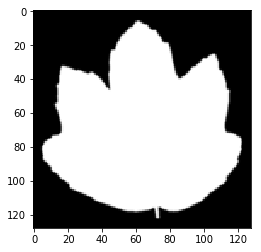

In [39]:
plt.imshow(image_data['1'], cmap='gray')
print (image_data['1'].shape)
plt.show()

In [40]:
# get labels
le = LabelEncoder()
le.fit(train.species)
#print(le.classes_)
#print(len(le.classes_))

LabelEncoder()

In [41]:
train_labels = le.transform(train.species)
#print(train_labels)
#print(len(train_labels))

In [42]:
# separate train and test from image_data
image_train = np.array([image_data[str(idx)] for idx in train.id])
image_test = np.array([image_data[str(idx)] for idx in test.id])
print (image_train.shape)
image_train = np.expand_dims(image_train, axis=4)
image_test = np.expand_dims(image_test, axis=4)
print(image_train.shape)
print(image_test.shape)

(990, 128, 128)
(990, 128, 128, 1)
(594, 128, 128, 1)


In [43]:
# # randomly split original train into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, val_index in sss.split(image_train, train_labels):
#     image_train_X, image_val_X = image_train[train_index], image_train[val_index]
#     image_train_Y, image_val_Y = train_labels[train_index], train_labels[val_index]
#     print(image_train_X.shape)
#     print(image_train_Y.shape)
#     print(image_val_X.shape)
#     print(image_val_Y.shape)
#     print("TRAIN:", train_index)
#     print("VAL:", val_index)
#     plt.imshow(image_train_X[0, :, :, 0], cmap='gray')
#     plt.show()
#     print(train_index[0])
#     print(image_train_Y[0])
#     print(le.inverse_transform([image_train_Y[0]]))

In [44]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 99
train_labels_cat = keras.utils.to_categorical(train_labels, num_classes)
#print(image_train.shape)
#print(train_labels_cat.shape)
#print(train_labels_cat[0,:])

In [59]:
# Keras expects batches of images, so we have to add a dimension to trick it into being nice
choosing_image = '7';
out_img = 0
path1 = 'static/output/layer'
path2 = '.png'
def visualize_leaf(model, im):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    #print im.shape
    global out_img
    global path1
    global path2
    leaf_batch = np.expand_dims(im,axis=3)
    leaf_batch = np.expand_dims(leaf_batch,axis=0)
    conv_leaf = model.predict(leaf_batch)
    conv_leaf = np.squeeze(conv_leaf, axis=0)
    #conv_leaf = conv_leaf.reshape(conv_leaf[0,:,:,0])
    #print conv_leaf[:,:,0]
    plt.imshow(conv_leaf[:,:,0], cmap='gray')
    path = path1+str(out_img)+path2
    plt.savefig(path)
    out_img = out_img+1
    #plt.show()
    #plt.imshow(layer0[0,:,:,0], cmap='gray')
    #plt.show()
    
def visualize_leaf_after_training(model, im, layer_name):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    #print im.shape
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
    leaf_batch = np.expand_dims(im,axis=3)
    leaf_batch = np.expand_dims(leaf_batch,axis=0)
    conv_leaf = intermediate_layer_model.predict(leaf_batch)
    conv_leaf = np.squeeze(conv_leaf, axis=0)
    #print conv_leaf[:,:,0]
    plt.imshow(conv_leaf[:,:,0], cmap='gray')
    plt.show()
    #plt.imshow(layer0[0,:,:,0], cmap='gray')
    #plt.show()

In [60]:
# build keras model for Images only
# model 1: following the CIFAR 10 example from Keras

img_model = Sequential()

layer0 = Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:])
layer1 = Activation('relu')
layer2 = Conv2D(32, (3, 3))
layer3 = Activation('relu')
layer4 = MaxPooling2D(pool_size=(2, 2))
layer5 = Dropout(0.25)

layer6 = Conv2D(64, (3, 3), padding='same')
layer7 = Activation('relu')
layer8 = Conv2D(64, (3, 3))
layer9 = Activation('relu')
layer10 = MaxPooling2D(pool_size=(2, 2))
layer11 = Dropout(0.25)

layer12 = Flatten()
layer13 = Dense(512)
layer14 = Activation('relu')
layer15 = Dropout(0.5)
layer16 = Dense(num_classes)
layer17 = Activation('softmax')

img_model.add(layer0)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer1)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer2)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer3)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer4)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer5)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer6)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer7)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer8)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer9)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer10)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer11)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer12)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer13)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer14)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer15)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer16)
visualize_leaf(img_model, image_data[choosing_image])
img_model.add(layer17)
visualize_leaf(img_model, image_data[choosing_image])

#img_model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:]))  
#visualize_leaf(img_model, image_data['1'])
#img_model.add(Activation('relu'))
#img_model.add(Conv2D(32, (3, 3)))
#img_model.add(Activation('relu'))
#img_model.add(MaxPooling2D(pool_size=(2, 2)))
#img_model.add(Dropout(0.25))

#img_model.add(Conv2D(64, (3, 3), padding='same'))
#img_model.add(Activation('relu'))
#img_model.add(Conv2D(64, (3, 3)))
#img_model.add(Activation('relu'))
#img_model.add(MaxPooling2D(pool_size=(2, 2)))
#img_model.add(Dropout(0.25))

#img_model.add(Flatten())
#img_model.add(Dense(512))
#img_model.add(Activation('relu'))
#img_model.add(Dropout(0.5))
#img_model.add(Dense(num_classes))
#img_model.add(Activation('softmax'))

json_image_model = img_model.to_json()

# Let's train the model using RMSprop
img_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print (layer0.get_weights())
#print (img_model.get_weights())

In [51]:
# output the model summary
#img_model.count_params()
#img_model.summary()

#img_model.fit(image_train, train_labels_cat,
#                            batch_size=16,
#                            epochs=10,
#                            validation_data=(image_train, train_labels_cat),
#                            validation_split=0.1,
#                            shuffle=True,
 #                           callbacks=[remote])
#img_model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, validation_data=(X_test, Y_test), callbacks=[remote])
#plot_model(img_model, to_file='model.png', show_shapes='True')
#SVG(model_to_dot(img_model).create(prog='dot', format='svg'))

In [61]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

@app.route('/')
def index():
    return render_template('image_model.html', data=json_image_model)
    #return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Apr/2017 22:13:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:52] "GET /static/output/layer3.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:54] "GET /static/output/layer7.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:55] "GET /static/output/layer8.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:56] "GET /static/output/layer9.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:56] "GET /static/output/layer10.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:13:58] "GET /static/output/layer13.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:14:00] "GET /static/output/layer15.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:14:00] "GET /static/output/layer16.png HTTP/1.1" 200 -
127.0.0.1 - - [25/Apr/2017 22:14:01] "GET /static/output/layer12.png HTTP/1.1" 200 -


In [192]:
#实时
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./1', histogram_freq=0, write_graph=True, write_images=True)

#img_model.fit(image_train, train_labels_cat,
#                            batch_size=16,
#                            epochs=10,
#                            validation_split=0.1,
#                            shuffle=True,
#                            callbacks=[tbCallBack])

In [193]:
#tbCallBack.set_model(img_model)

In [194]:
img_history = img_model.fit(image_train, train_labels_cat,
                            batch_size=16,
                            epochs=10,
                            validation_split=0.1,
                            shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/10
891/891 [==============================] - 75s - loss: 15.8773 - acc: 0.0135 - val_loss: 15.8305 - val_acc: 0.0101

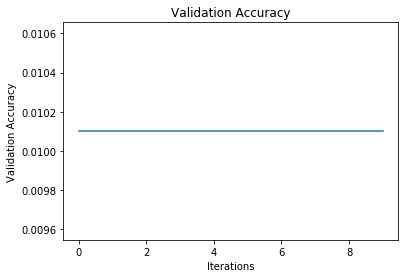

[array([[[[-0.04275661,  0.10828808,  0.09119792, -0.01191473,  0.09058084,
           0.11278026, -0.03227141,  0.12949599,  0.04204217,  0.02963506,
           0.02550674, -0.13597618,  0.02352274, -0.09440336, -0.07180013,
           0.14301051, -0.05643927,  0.05697409,  0.00713739, -0.0600935 ,
          -0.01836501,  0.11109196,  0.13490824,  0.01587741, -0.01296736,
          -0.09156329,  0.02882116, -0.0484611 , -0.00966617,  0.03837125,
          -0.03094801, -0.00690052]],

        [[-0.08647768,  0.03131661,  0.07643476, -0.03117922, -0.08680815,
           0.11601625, -0.13955079, -0.00614248, -0.11418849,  0.08773789,
          -0.12833926,  0.1154918 ,  0.02231753, -0.13995843, -0.03189375,
          -0.09934729,  0.06701579,  0.044527  ,  0.06533304, -0.1463085 ,
           0.13252418, -0.05152462, -0.10934947,  0.11738621,  0.01025899,
          -0.00679052,  0.09735844,  0.11593179,  0.00869779, -0.06102366,
           0.12600769, -0.12378019]],

        [[ 0.14121638

In [196]:
plt.plot(img_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()
img_model.save_weights('img_model_weight.h5');
#visualize_leaf(img_model, image_data[choosing_image])
#plot_model(img_model, to_file='model.png')
print img_model.layers[0].get_weights()
print img_model.layers[1].get_weights()
print img_model.layers[2].get_weights()
print img_model.layers[3].get_weights()
print img_model.layers[4].get_weights()
print img_model.layers[5].get_weights()
print img_model.layers[6].get_weights()

In [210]:
img_model_pred = Sequential()

layer_pred0 = Conv2D(32, (3, 3), padding='same', input_shape=image_train.shape[1:], weights=img_model.layers[0].get_weights())
layer_pred1 = Activation('relu')
layer_pred2 = Conv2D(32, (3, 3), weights=img_model.layers[2].get_weights())
layer_pred3 = Activation('relu')
layer_pred4 = MaxPooling2D(pool_size=(2, 2))
layer_pred5 = Dropout(0.25)

layer_pred6 = Conv2D(64, (3, 3), padding='same', weights=img_model.layers[6].get_weights())
layer_pred7 = Activation('relu')
layer_pred8 = Conv2D(64, (3, 3), weights=img_model.layers[8].get_weights())
layer_pred9 = Activation('relu')
layer_pred10 = MaxPooling2D(pool_size=(2, 2))
layer_pred11 = Dropout(0.25)

layer_pred12 = Flatten()
layer_pred13 = Dense(512, weights=img_model.layers[13].get_weights())
layer_pred14 = Activation('relu')
layer_pred15 = Dropout(0.5)
layer_pred16 = Dense(num_classes, weights=img_model.layers[16].get_weights())
layer_pred17 = Activation('softmax')

img_model_pred.add(layer_pred0)
#print img_model_pred.layers[0].get_weights()
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred1)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred2)
#print img_model.layers[2].get_weights()
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred3)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred4)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred5)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred6)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred7)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred8)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred9)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred10)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred11)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred12)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred13)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred14)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred15)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred16)
visualize_leaf(img_model_pred, image_data[choosing_image])
img_model_pred.add(layer_pred17)
visualize_leaf(img_model_pred, image_data[choosing_image])



In [143]:
#visualize_leaf_after_training(img_model, image_data[choosing_image], layer0)

AttributeError: 'NoneType' object has no attribute 'output'

In [78]:
#test weight for the first Conv2D layer
print (layer0.get_weights()[0][0][0][0][0])
print (layer0.get_weights()[0][0][1][0][0])
print (layer0.get_weights()[0][0][2][0][0])
print (layer0.get_weights()[0][1][0][0][0])
print (layer0.get_weights()[0][1][1][0][0])
print (layer0.get_weights()[0][1][2][0][0])
print (layer0.get_weights()[0][2][0][0][0])
print (layer0.get_weights()[0][2][1][0][0])
print (layer0.get_weights()[0][2][2][0][0])

-0.0305539
0.0075953
-0.121683
-0.0647699
0.0338868
-0.0925213
-0.0219671
-0.0631593
-0.0846476


In [ ]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    #return render_template('image_model.html', data=json_image_model)
    return layer0.get_weights()[0].toString()
if __name__ == '__main__':
    app.run()

### Using Features Only

In [188]:
# build keras model for Features only
feat_model = Sequential()
feat_model.add(Dense(512, input_dim=192, kernel_initializer='uniform', activation='relu'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(256, activation='sigmoid'))
feat_model.add(Dropout(0.3))
feat_model.add(Dense(99, activation='softmax'))

json_feat_model = feat_model.to_json()
feat_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [190]:
#build html page to show real time model

app = Flask(__name__)
Bootstrap(app)

#@app.route('/_send_json')
#def sendjson():
#    return json_image_model

@app.route('/')
def index():
    return render_template('image_model.html', data=json_feat_model)
    #return json_image_model
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Apr/2017 23:24:02] "GET / HTTP/1.1" 200 -


In [18]:
# output the model summary
feat_model.count_params()
feat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 99)                25443     
Total params: 255,587
Trainable params: 255,587
Non-trainable params: 0
_________________________________________________________________


In [19]:
feat_history = feat_model.fit(feat_train, train_labels_cat,
                              batch_size=16,
                              epochs=50,
                              validation_split=0.1,
                              shuffle=True)

Train on 891 samples, validate on 99 samples
Epoch 1/50
891/891 [==============================] - 0s - loss: 4.2385 - acc: 0.1257 - val_loss: 3.5214 - val_acc: 0.4141
Epoch 2/50
891/891 [==============================] - 0s - loss: 2.9184 - acc: 0.4658 - val_loss: 2.4385 - val_acc: 0.7172
Epoch 3/50
891/891 [==============================] - 0s - loss: 1.8962 - acc: 0.7149 - val_loss: 1.5068 - val_acc: 0.8384

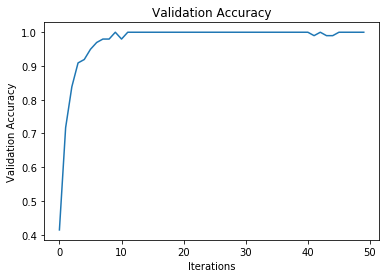

In [20]:
plt.plot(feat_history.history['val_acc'])
plt.xlabel('Iterations')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [22]:
# do prediction
pred = feat_model.predict_proba(feat_test)
columns = sorted(train.species.unique())
pred = pandas.DataFrame(pred, index=test.id, columns=columns)
output = open('prediction_fully_connected.csv','w')
output.write(pred.to_csv())
output.close()

 32/594 [>.............................] - ETA: 0s